In [1]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization, Activation
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import confusion_matrix
import numpy as np
import matplotlib.pyplot as plt

from glob import glob
import itertools
import os

In [2]:
IMAGE_SIZE = [100, 100]

In [3]:
train_path = 'large_files/fruits-360-original-size/fruits-360-original-size/Training'
valid_path = 'large_files/fruits-360-original-size/fruits-360-original-size/Validation'

In [4]:
image_files = []
for category in os.listdir(train_path):
    category_path = os.path.join(train_path, category)
    if os.path.isdir(category_path):
        for file_name in os.listdir(category_path):
            if file_name.endswith('.jpg'):
                image_files.append(os.path.join(category_path, file_name))

In [5]:
valid_image_files = []
for category in os.listdir(valid_path):
    category_path = os.path.join(valid_path, category)
    if os.path.isdir(category_path):
        for file_name in os.listdir(category_path):
            if file_name.endswith('.jpg'):
                valid_image_files.append(os.path.join(category_path, file_name))

In [6]:
folders = glob(train_path + '/*')

In [7]:
resnet = ResNet50(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

In [8]:
for layer in resnet.layers:
    layer.trainable = False

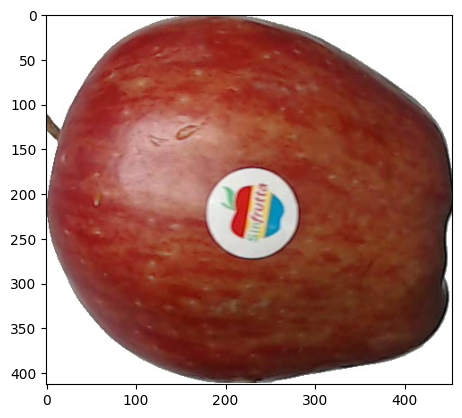

In [9]:
plt.imshow(image.load_img(np.random.choice(image_files)))

In [10]:
x = Flatten()(resnet.output)

prediction = Dense(len(folders), activation='softmax')(x)

In [11]:
model = Model(inputs=resnet.input, outputs=prediction)

In [12]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 100, 100, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 106, 106, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 50, 50, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 50, 50, 64)   256         conv1_conv[0][0]                 
______________________________________________________________________________________________

In [13]:
model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

In [14]:
gen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    preprocessing_function=preprocess_input
)

In [15]:
batch_size = 32

In [16]:
train_generator = gen.flow_from_directory(
    train_path,
    target_size=IMAGE_SIZE,
    shuffle=True,
    batch_size=batch_size
)

Found 6231 images belonging to 24 classes.


In [17]:
valid_generator = gen.flow_from_directory(
    valid_path,
    target_size=IMAGE_SIZE,
    shuffle=True,
    batch_size=batch_size
)

Found 3114 images belonging to 24 classes.


In [18]:
!rm -rf logs

In [19]:
%load_ext tensorboard

In [20]:
log_path = 'logs/fit'

import tensorflow as tf

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_path, histogram_freq=1)

r = model.fit(
    train_generator,
    validation_data=valid_generator,
    epochs=5,
    steps_per_epoch=len(image_files) // batch_size,
    validation_steps=len(valid_image_files) // batch_size,
    callbacks=[tensorboard_callback]
)

C:\Users\Andrei\anaconda3\envs\tfenv\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 1/5
194/194 [==============================] - 40s 180ms/step - loss: 1.2901 - accuracy: 0.8621 - val_loss: 0.3627 - val_accuracy: 0.9543
Epoch 2/5
194/194 [==============================] - 31s 160ms/step - loss: 0.3251 - accuracy: 0.9558 - val_loss: 0.1970 - val_accuracy: 0.9713
Epoch 3/5
194/194 [==============================] - 31s 159ms/step - loss: 0.3161 - accuracy: 0.9616 - val_loss: 0.2372 - val_accuracy: 0.9758
Epoch 4/5
194/194 [==============================] - 31s 161ms/step - loss: 0.3002 - accuracy: 0.9663 - val_loss: 0.0975 - val_accuracy: 0.9874
Epoch 5/5
194/194 [==============================] - 33s 170ms/step - loss: 0.2712 - accuracy: 0.9745 - val_loss: 0.2540 - val_accuracy: 0.9791


In [21]:
%tensorboard --logdir logs/fit

Launching TensorBoard...

In [22]:
from tensorboard import program

tracking_address = log_path # the path of your log file.
tb = program.TensorBoard()
tb.configure(argv=[None, '--logdir', tracking_address])
url = tb.launch()
print(f"Tensorflow listening on {url}")

Tensorflow listening on http://localhost:6006/
